In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, DistributedSampler
import numpy as np
from matplotlib import pyplot as plt
import os
from tensorboardX import SummaryWriter
import time
from skimage import io, transform

In [3]:
import cv2

# Make folder to save model and tensorboard

In [4]:
date_folder='C:/Users/piyalong/TAMIDS_point/20230824/'

output_dir=os.path.join(date_folder,'out/')

tensorboard_dir=os.path.join(date_folder,'tensorboard/')
checkpoints_dir=os.path.join(date_folder,'ckpts/')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(tensorboard_dir):
    os.makedirs(tensorboard_dir)
if not os.path.exists(checkpoints_dir):
    os.makedirs(checkpoints_dir)

In [5]:
date_folder

'C:/Users/piyalong/TAMIDS_point/20230824/'

In [6]:
tensorboard_dir

'C:/Users/piyalong/TAMIDS_point/20230824/tensorboard/'

# Build Model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Backbone_VGG(nn.Module):
    def __init__(self):
        super(Backbone_VGG, self).__init__()
        self.body1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.body2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.body3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.body4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        out1 = self.body1(x)
        out2 = self.body2(out1)
        out3 = self.body3(out2)
        out4 = self.body4(out3)
        
        return out1, out2, out3, out4


class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.conv1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.conv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act4 = nn.ReLU()
        self.output = nn.Conv2d(256, 8, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)
        out = self.conv2(out)
        out = self.act2(out)
        out = self.conv3(out)
        out = self.act3(out)
        out = self.conv4(out)
        out = self.act4(out)
        out = self.output(out)
        
        out = out.permute(0, 2, 3, 1)

        return out.contiguous().view(out.shape[0], -1, 2)


class ClassificationModel(nn.Module):
    def __init__(self, num_features_in=256, num_anchor_points=4, num_classes=2, prior=0.01, feature_size=256):
        super(ClassificationModel, self).__init__()

        self.num_classes = num_classes
        self.num_anchor_points = num_anchor_points

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, num_anchor_points * num_classes, kernel_size=3, padding=1)
        self.output_act = nn.Sigmoid()
        
    # sub-branch forward
    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.output(out)

        out1 = out.permute(0, 2, 3, 1)

        batch_size, width, height, _ = out1.shape

        out2 = out1.view(batch_size, width, height, self.num_anchor_points, self.num_classes)

        return out2.contiguous().view(x.shape[0], -1, self.num_classes)

class AnchorPoints(nn.Module):
    def __init__(self, pyramid_levels=None, strides=None, row=3, line=3):
        super(AnchorPoints, self).__init__()

        if pyramid_levels is None:
            self.pyramid_levels = [3, 4, 5, 6, 7]
        else:
            self.pyramid_levels = pyramid_levels

        if strides is None:
            self.strides = [2 ** x for x in self.pyramid_levels]

        self.row = row
        self.line = line

    def forward(self, image):
        image_shape = image.shape[2:]
        image_shape = np.array(image_shape)
        image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in self.pyramid_levels]

        all_anchor_points = np.zeros((0, 2)).astype(np.float32)
        # get reference points for each level
        for idx, p in enumerate(self.pyramid_levels):
            anchor_points = generate_anchor_points(2**p, row=self.row, line=self.line)
            shifted_anchor_points = shift(image_shapes[idx], self.strides[idx], anchor_points)
            all_anchor_points = np.append(all_anchor_points, shifted_anchor_points, axis=0)

        all_anchor_points = np.expand_dims(all_anchor_points, axis=0)
        # send reference points to device
        if torch.cuda.is_available():
            return torch.from_numpy(all_anchor_points.astype(np.float32)).cuda()
        else:
            return torch.from_numpy(all_anchor_points.astype(np.float32))
def generate_anchor_points(stride=16, row=3, line=3):
    row_step = stride / row
    line_step = stride / line

    shift_x = (np.arange(1, line + 1) - 0.5) * line_step - stride / 2
    shift_y = (np.arange(1, row + 1) - 0.5) * row_step - stride / 2

    shift_x, shift_y = np.meshgrid(shift_x, shift_y)

    anchor_points = np.vstack((
        shift_x.ravel(), shift_y.ravel()
    )).transpose()

    return anchor_points

def shift(shape, stride, anchor_points):
    shift_x = (np.arange(0, shape[1]) + 0.5) * stride
    shift_y = (np.arange(0, shape[0]) + 0.5) * stride

    shift_x, shift_y = np.meshgrid(shift_x, shift_y)

    shifts = np.vstack((
        shift_x.ravel(), shift_y.ravel()
    )).transpose()

    A = anchor_points.shape[0]
    K = shifts.shape[0]
    all_anchor_points = (anchor_points.reshape((1, A, 2)) + shifts.reshape((1, K, 2)).transpose((1, 0, 2)))
    all_anchor_points = all_anchor_points.reshape((K * A, 2))

    return all_anchor_points


class Decoder(nn.Module):
    def __init__(self, C3_size, C4_size, C5_size, feature_size=256):
        super(Decoder, self).__init__()

        # upsample C5 to get P5 from the FPN paper
        self.P5_1 = nn.Conv2d(C5_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P5_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P5_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P5 elementwise to C4
        self.P4_1 = nn.Conv2d(C4_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P4_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P4_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P4 elementwise to C3
        self.P3_1 = nn.Conv2d(C3_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P3_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P3_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)


    def forward(self, inputs):
        C3, C4, C5 = inputs

        P5_x = self.P5_1(C5)
        P5_upsampled_x = self.P5_upsampled(P5_x)
        P5_x = self.P5_2(P5_x)

        P4_x = self.P4_1(C4)
        P4_x = P5_upsampled_x + P4_x
        P4_upsampled_x = self.P4_upsampled(P4_x)
        P4_x = self.P4_2(P4_x)

        P3_x = self.P3_1(C3)
        P3_x = P3_x + P4_upsampled_x
        P3_x = self.P3_2(P3_x)

        return [P3_x, P4_x, P5_x]


class P2PNet(nn.Module):
    def __init__(self):
        super(P2PNet, self).__init__()
        self.backbone = Backbone_VGG()
        self.regression = RegressionModel()
        self.classification = ClassificationModel()
        self.anchor_points = AnchorPoints(pyramid_levels=[3,], row=2, line=2)
        self.fpn =  Decoder(256, 512, 512)

    def forward(self, x):
        features = self.backbone(x)
        features_fpn = self.fpn([features[1], features[2], features[3]])
        
        batch_size = features[0].shape[0]
        regression_out = self.regression(features_fpn[1]) * 100 # 8x
        classification_out = self.classification(features_fpn[1])
        anchor_points_out = self.anchor_points(x).repeat(batch_size, 1, 1)
        
        output_coord = regression_out.to(device) + anchor_points_out.to(device)
        
        output_class = classification_out
        out = {'pred_logits': output_class, 'pred_points': output_coord}
       
        return out


In [8]:
# Create an instance of the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = P2PNet()
PATH='D:/best_mae (1).pth'
# PATH=checkpoints_dir+'/latest.pth'

checkpoint = torch.load(PATH, map_location=device)
model.load_state_dict(checkpoint['model'])
model.to(device)
model.eval();

# Custom Dataset

In [9]:
def resize_image_with_annotations(image, target, new_size):
    # Open the image
    h, w = image.shape[:2]
    points=target['points']
    # Calculate the scaling factors for x and y dimensions
    scale_x = new_size[0] / w
    scale_y = new_size[1] / h

    # Resize the image
    resized_image = cv2.resize(image,new_size)

    # Resize and adjust the point annotations
    resized_points = [(int(x * scale_x), int(y * scale_y)) for x, y in points]
    target['points']= torch.Tensor(resized_points)
    return resized_image, target

In [10]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.targets = []
        
        for filename in os.listdir(root_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                img_path = os.path.join(root_dir, filename)
                self.images.append(img_path)
                
                target = os.path.join(root_dir, filename[:-4]+'.txt')
                self.targets.append(target)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        assert idx <= len(self), 'index range error'
        img_path = self.images[idx]
        gt_path = self.targets[idx]
        
        image_bgr = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        
        points = []
        with open(gt_path) as f_label:
            for line in f_label:
                x = float(line.strip().split(' ')[0])
                y = float(line.strip().split(' ')[1])
                points.append([x, y])
        
        target={}
        target['points'] = torch.Tensor(points)
        target['image_ids']=torch.Tensor(idx)
        target['labels'] = torch.ones(len(points)).long()
        
        new_size=(1024,1024)
        img, target=resize_image_with_annotations(image_rgb,target,new_size)
        # img=image_rgb
        img = self.transform(img) 
        
        return img, target
    

In [11]:
datatransform = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],    std=[0.229, 0.224, 0.225]),
                                    # transforms.Resize(new_size),   
                                           ])

In [12]:
def collate_fn(batch):
    images = list()
    targets = list()

    for img, target in batch:
        images.append(img)
        targets.append(target)
    
    images = torch.stack(images, dim=0)
    
    return images.float().to(device), targets 

In [127]:
batch_size=1

dataset_train=CustomDataset('D:/20230426CDI/data/train/',datatransform)

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn,shuffle=True)

dataset_test=CustomDataset('D:/20230426CDI/data/test/',datatransform)
# dataset_test=CustomDataset('D:/20230427_New_Dataset-20230824T214952Z-001/20230427_New_Dataset/new_data/data/test/',datatransform)

data_loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn,shuffle=True)

In [137]:
total_tp=total_gt=total_pred=0
i=0

for batch_images, batch_labels in data_loader_train:
  
        total_gt+=len(y_true)
        total_pred+=len(points)
total_gt

2610

In [138]:
len(dataset_train)

90

In [139]:
len(dataset_test)

21

# Show some annotation examples

In [130]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

(1024, 1024, 3) 1.0


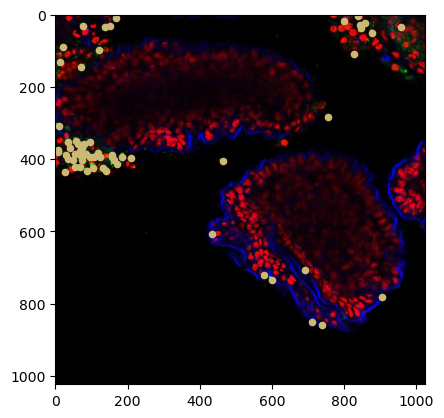

In [131]:
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

for batch_images, batch_labels in data_loader_test:
    for image,target in zip(batch_images, batch_labels):
        image=unorm(image)
        landmarks=target['points']
        image_numpy=image.cpu().numpy().copy()
        image_numpy = np.transpose(image_numpy, (1, 2, 0))
        
        print(image_numpy.shape,image_numpy.max())
        plt.imshow(image_numpy)
        plt.scatter(landmarks[:, 0], landmarks[:, 1], s=20, marker='o', c='y')
        plt.pause(0.001)  # pause a bit so that plots are updated
    
        break
    break

# Evaluation

## Hungarian match again to see TP. This matching is different from the training match because training matches every possible point. 

In [132]:
from scipy.optimize import linear_sum_assignment
import numpy as np

def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

def match_resutls(predicted_points, gt_points):

    if len(predicted_points) >= len(gt_points):
        n_rows =n_cols=len(predicted_points)
    else:
        n_cols = n_rows =len(gt_points)

    cost_matrix = np.zeros((n_rows, n_cols))

    for i, pred_point in enumerate(predicted_points):
        for j, gt_point in enumerate(gt_points):
            cost_matrix[i, j] = euclidean_distance(pred_point, gt_point)
            
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    return cost_matrix, row_indices, col_indices

In [133]:
total_gt

12

In [134]:
import matplotlib
matplotlib.rc_file_defaults()

In [135]:
total_tp=total_gt=total_pred=0
i=0

for batch_images, batch_labels in data_loader_test:
    with torch.no_grad():
        outputs =     model(batch_images)

    for image,target,pred_logits, pred_points in zip(batch_images, batch_labels,outputs['pred_logits'],outputs['pred_points']):
        image=unorm(image)
        outputs_scores = torch.nn.functional.softmax(pred_logits, -1)[:, 1]
        points = pred_points[outputs_scores > 0.45].cpu().numpy()
        
        image_numpy = np.transpose(image.cpu(), (1, 2, 0))
        img_to_draw=image_numpy.numpy().copy() 
                
        y_true=target['points'].detach().cpu().numpy()
        
        cost_matrix,row_indices, col_indices=match_resutls(points, y_true)
        size=50
        tp=0

        yellow2=plt.scatter(y_true[:, 0], y_true[:, 1], s=size, marker='o', c='y', label='GT')
        yellow1=plt.scatter(points[:, 0], points[:, 1], s=size, marker='+', c='y', label='CV')
        
        for row, col in zip(row_indices, col_indices):
            if row < len(points) and col < len(y_true):
                pred_point = points[row]
                gt_point = y_true[col]
                if cost_matrix[row, col]<size:
                    circles=plt.scatter(gt_point[0], gt_point[1], s=size, marker='o', c='g', label='GT')
                    crosses=plt.scatter(pred_point[0], pred_point[1], s=size, marker='+', c='w', label='CV')
                    tp+=1
        
        total_tp+=tp
        total_gt+=len(y_true)
        total_pred+=len(points)
        
        print(f' TP {tp} precision {tp/len(points) } recall {tp/len(y_true)}')
        # print(target['image_ids'].numpy())
        custom_legend_labels = ['TP CV', 'TP GT', 'Unmatched CV','Unmatched GT']
        custom_legend_handles = [crosses, circles,yellow1,yellow2]
        # Add a custom legend
        plt.legend(custom_legend_handles, custom_legend_labels)
        plt.imshow(img_to_draw)
        plt.savefig(f'Evaluation/{i}.jpg',bbox_inches='tight')
        plt.clf()

        i+=1
        # break
    # break
print(f'total TP {total_tp} precision {total_tp/total_pred } recall {total_tp/total_gt}')

 TP 17 precision 0.9444444444444444 recall 0.7083333333333334
 TP 12 precision 1.0 recall 0.9230769230769231
 TP 48 precision 0.8421052631578947 recall 0.8135593220338984
 TP 11 precision 0.6875 recall 0.9166666666666666
 TP 12 precision 0.8 recall 0.8571428571428571
 TP 3 precision 1.0 recall 1.0
 TP 53 precision 0.8688524590163934 recall 0.8833333333333333
 TP 14 precision 0.9333333333333333 recall 0.7
 TP 12 precision 0.8 recall 0.8571428571428571
 TP 12 precision 1.0 recall 1.0
 TP 11 precision 0.8461538461538461 recall 0.9166666666666666
 TP 4 precision 0.6666666666666666 recall 0.5714285714285714
 TP 9 precision 0.6428571428571429 recall 1.0
 TP 17 precision 0.85 recall 1.0
 TP 44 precision 0.8627450980392157 recall 0.8979591836734694
 TP 10 precision 0.7692307692307693 recall 0.9090909090909091
 TP 5 precision 0.8333333333333334 recall 1.0
 TP 56 precision 0.835820895522388 recall 0.8615384615384616
 TP 48 precision 0.8421052631578947 recall 0.8135593220338984
 TP 6 precision 1.

<Figure size 640x480 with 0 Axes>

In [126]:
y_true

array([], dtype=float32)

In [101]:
total_gt

501

In [102]:
total_pred

501

In [19]:
y_true.shape

(29, 2)

In [20]:
target['image_ids'].numpy()

array([ 5.8100098e+17,  1.2863672e-28,  2.2110844e-18,  7.8649176e-18,
        1.4570262e-01,  1.4394819e-25,  7.6592894e+36, -3.2917771e-04,
        4.5447970e+32], dtype=float32)

In [21]:
def run(threshold,size=100):
    total_tp=total_gt=total_pred=0
    i=0
    
    for batch_images, batch_labels in data_loader_test:
        with torch.no_grad():
            outputs =     model(batch_images)
    
        for image,target,pred_logits, pred_points in zip(batch_images, batch_labels,outputs['pred_logits'],outputs['pred_points']):
            image=unorm(image)
            outputs_scores = torch.nn.functional.softmax(pred_logits, -1)[:, 1]
            points = pred_points[outputs_scores > threshold].cpu().numpy()
            
            image_numpy = np.transpose(image.cpu(), (1, 2, 0))
            img_to_draw=image_numpy.numpy().copy() 
                    
            y_true=target['points'].detach().cpu().numpy()
            
            cost_matrix,row_indices, col_indices=match_resutls(points, y_true)
            
            tp=0
    
            yellow2=plt.scatter(y_true[:, 0], y_true[:, 1], s=size, marker='o', c='y', label='GT')
            yellow1=plt.scatter(points[:, 0], points[:, 1], s=size, marker='+', c='y', label='CV')
            
            for row, col in zip(row_indices, col_indices):
                if row < len(points) and col < len(y_true):
                    pred_point = points[row]
                    gt_point = y_true[col]
                    if cost_matrix[row, col]<size:
                        circles=plt.scatter(gt_point[0], gt_point[1], s=size, marker='o', c='g', label='GT')
                        crosses=plt.scatter(pred_point[0], pred_point[1], s=size, marker='+', c='w', label='CV')
                        tp+=1
            
            total_tp+=tp
            total_gt+=len(y_true)
            total_pred+=len(points)
            
            print(f' TP {tp} precision {tp/len(points) } recall {tp/len(y_true)}')
            # print(target['image_ids'].numpy())
            custom_legend_labels = ['TP CV', 'TP GT', 'Unmatched CV','Unmatched GT']
            custom_legend_handles = [crosses, circles,yellow1,yellow2]
            # Add a custom legend
            # plt.legend(custom_legend_handles, custom_legend_labels)
            # plt.imshow(img_to_draw)
            # plt.savefig(f'Evaluation/{i}.jpg')
            # plt.clf()
    
            i+=1
            # break
        # break
    print(f'total TP {total_tp} precision {total_tp/total_pred } recall {total_tp/total_gt}')
    return total_tp/total_pred,total_tp/total_gt

In [ ]:

results=[]
for s in [10,50,100]:
    result=[]
    for t in np.arange(0.01,1,0.1):
        p,r=run(t,s)
        result.append([p,r])
    results.append(result)

In [29]:
for t in np.arange(0.01,1,0.1):
    print(t)

0.01
0.11
0.21000000000000002
0.31000000000000005
0.41000000000000003
0.51
0.6100000000000001
0.7100000000000001
0.81
0.91


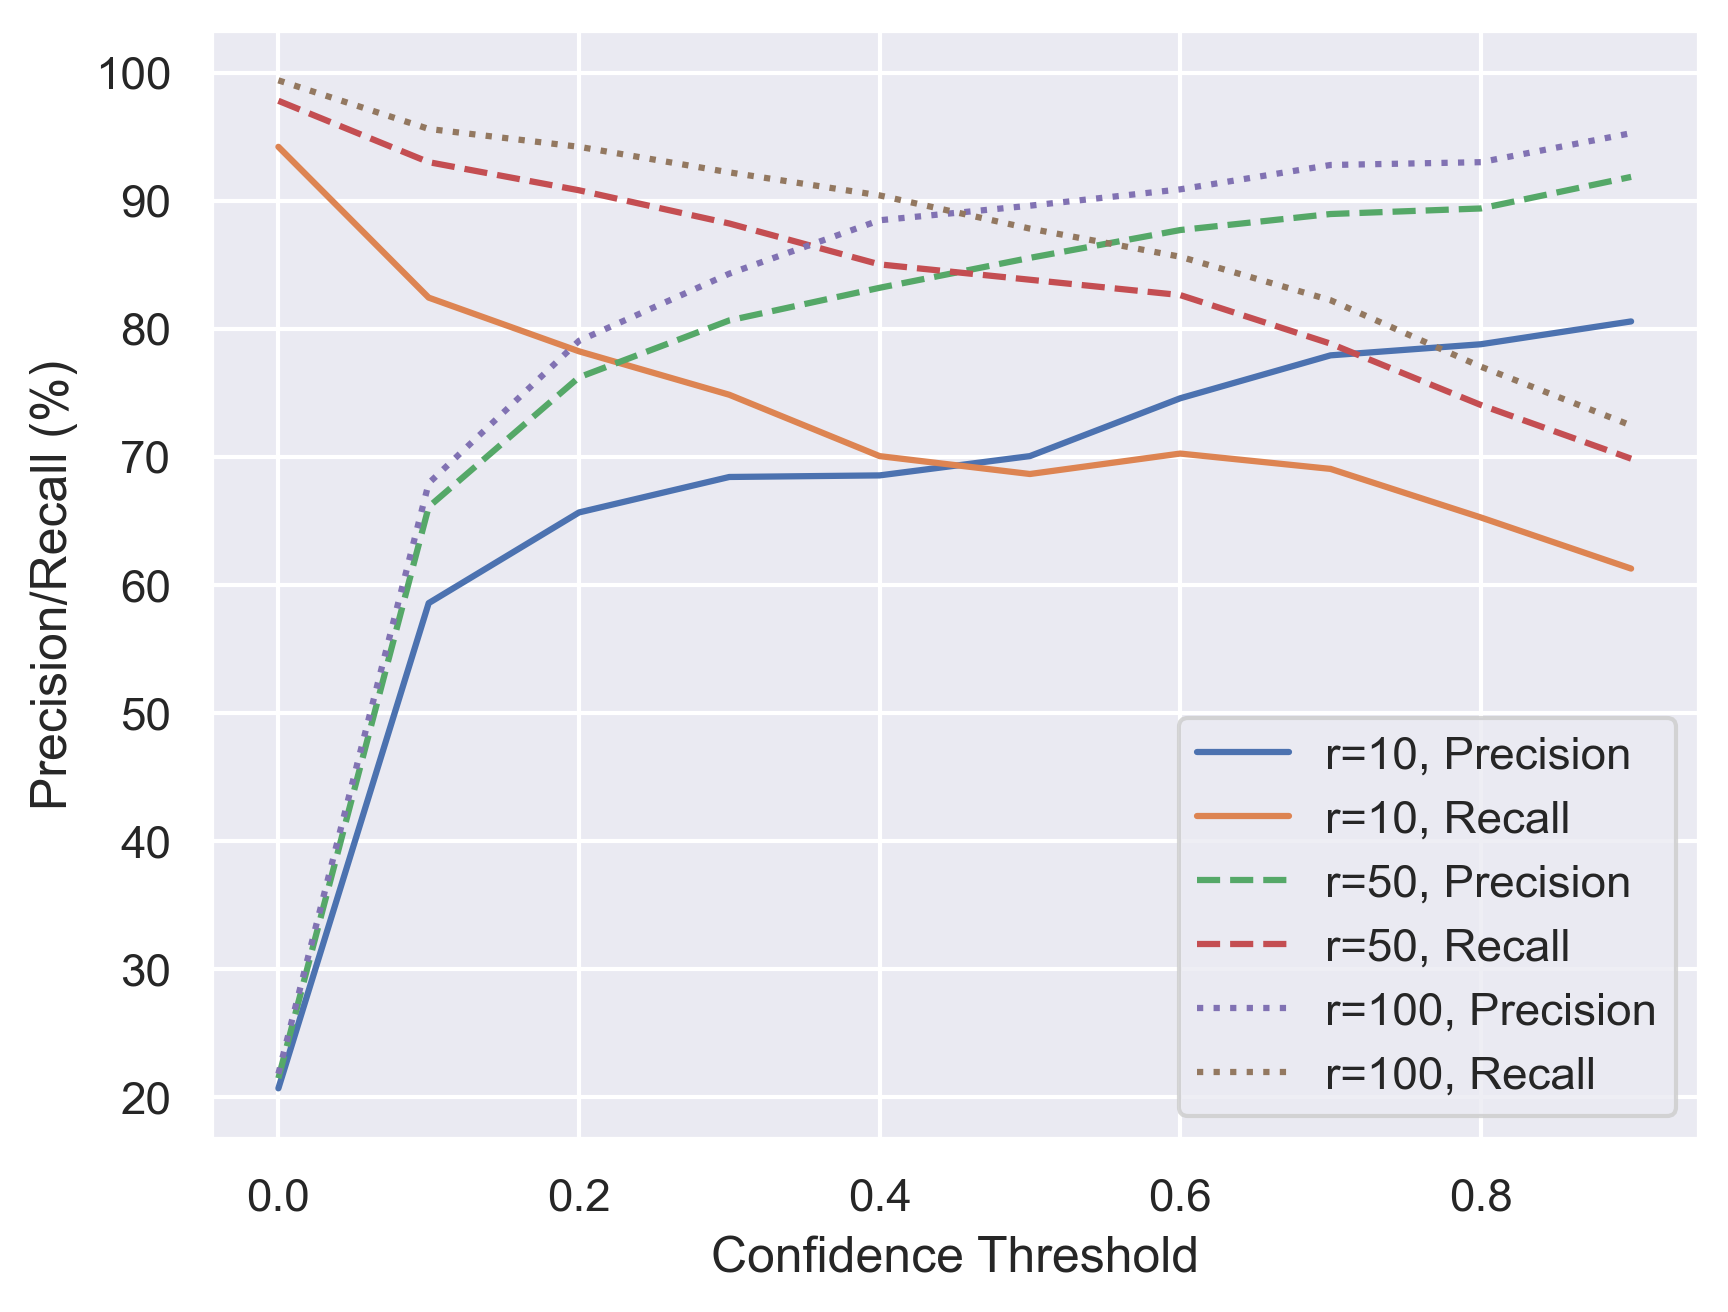

In [140]:
import seaborn as sns
plt.figure(dpi=300)
# Apply the default theme
sns.set_theme()
# arr=arr/100
plt.plot(np.arange(0.0,1,0.1),arr[0,:,0],label='r=10, Precision')
plt.plot(np.arange(0.0,1,0.1),arr[0,:,1],label='r=10, Recall')
plt.plot(np.arange(0.0,1,0.1),arr[1,:,0],'--',label='r=50, Precision')
plt.plot(np.arange(0.0,1,0.1),arr[1,:,1],'--',label='r=50, Recall')
plt.plot(np.arange(0.0,1,0.1),arr[2,:,0],':',label='r=100, Precision')
plt.plot(np.arange(0.0,1,0.1),arr[2,:,1],':',label='r=100, Recall')
plt.legend()

plt.xlabel('Confidence Threshold')
plt.ylabel('Precision/Recall (%)')

plt.savefig('size_threshold_precision_recall.jpg',bbox_inches='tight')